### Formatting Data

In [ ]:
import pandas as pd
import requests
import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import tabulate

# Formatting South African Heart Data
def sa_heart_data():
  url="https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data"
  s = requests.get(url).content
  df = pd.read_csv(io.StringIO(s.decode('utf-8'))).sample(frac=1)
  df = df.drop(columns=df.columns[0])
  df.replace({'Present': 1, 'Absent': -1}, inplace=True)
  #df = pd.read_csv("sa_heart.csv").sample(frac=1)
  train, test_val = train_test_split(df, test_size=0.2)
  test, val = train_test_split(df, test_size=0.2)

  ones_col = np.ones(len(train))
  training_features = train.drop(columns = train.columns[-1])
  mean = training_features.mean()
  std = training_features.std()
  training_features = (training_features - mean)/std
  training_features.insert(0,'Intercept',np.ones(len(train)),True)
  training_labels = train.drop(columns = train.columns[:-1])

  validation_features = val.drop(columns = val.columns[-1])
  validation_features = (validation_features - mean)/std
  validation_features.insert(0,'Intercept',np.ones(len(val)),True)
  validation_labels = val.drop(columns = val.columns[:-1])
  
  testing_features = test.drop(columns = test.columns[-1])
  testing_features = (testing_features - mean)/std
  testing_features.insert(0,'Intercept',np.ones(len(test)),True)
  testing_labels = test.drop(columns = test.columns[:-1])

  return df, training_features.to_numpy(), training_labels.to_numpy(), validation_features.to_numpy(), validation_labels.to_numpy(), testing_features.to_numpy(), testing_labels.to_numpy()

# Formatting Cervical Cancer Data
def cervical_cancer():
  url= "https://archive.ics.uci.edu/ml/machine-learning-databases/00537/sobar-72.csv"
  s = requests.get(url).content
  df = pd.read_csv(io.StringIO(s.decode('utf-8'))).sample(frac=1)
  train, test_val = train_test_split(df, test_size=0.2)
  test, val = train_test_split(df, test_size=0.2)

  ones_col = np.ones(len(train))
  training_features = train.drop(columns = train.columns[-1])
  mean = training_features.mean()
  std = training_features.std()
  training_features = (training_features - mean)/std
  training_features.insert(0,'Intercept',np.ones(len(train)),True)
  training_labels = train.drop(columns = train.columns[:-1])

  validation_features = val.drop(columns = val.columns[-1])
  validation_features = (validation_features - mean)/std
  validation_features.insert(0,'Intercept',np.ones(len(val)),True)
  validation_labels = val.drop(columns = val.columns[:-1])
  
  testing_features = test.drop(columns = test.columns[-1])
  testing_features = (testing_features - mean)/std
  testing_features.insert(0,'Intercept',np.ones(len(test)),True)
  testing_labels = test.drop(columns = test.columns[:-1])

  return df, training_features.to_numpy(), training_labels.to_numpy(), validation_features.to_numpy(), validation_labels.to_numpy(), testing_features.to_numpy(), testing_labels.to_numpy()

### Regression Functions

In [ ]:
# Sigmoid Function
def sigmoid(thetas, x):
  x = x.reshape(-1, thetas.shape[1])
  den = 1 + np.exp(- (thetas @ x.T))
  return (1 / den).flatten()

# Updating Weights with or without regularization
def weight_update(features, labels, alpha, thetas, reg, use_l1 = False, use_l2 = False, lam=None):
  reg = 0
  L1_norm = 0
  for j in range(thetas.shape[1]):
    if reg != 0:
      L1_norm = np.sum(np.absolute(thetas))

    l1 = 0
    l2 = 0
    if lam != None:
      l1 = (lam/len(labels))*np.sign(thetas[0, j])
      l2 = 2*(lam/len(labels))*(thetas[0, j])

    thetas[0, j] = thetas[0, j] + alpha * (labels - sigmoid(thetas, features)) * features[j] - (l1 if use_l1 else 0) - (l2 if use_l2 else 0)

  return thetas, L1_norm

# Training
def train(features, labels, alpha, thetas_initial, lam=None, iterations=1, use_l1 = False, use_l2 = False):
  thetas = thetas_initial
  L1_norm = 0
  for i in range(iterations):
    batch = np.random.randint(len(features)-1)
    h = sigmoid(thetas, features)
    reg = 0 if not use_l1 and not use_l2 else (1 if use_l1 else 2)
    thetas, L1_norm = weight_update(features[batch, :], labels[batch], alpha, thetas, reg, lam = lam)
  return thetas, L1_norm

# Determine accuracy of model
def percent_correct(features, labels, thetas):
  x = np.array(features)
  y = np.array(labels)
  yh = np.zeros(len(y))
  correct = 0
  for i in range(0,len(x)):
    h = sigmoid(thetas,x[i])
    yi = y[i]
    yh[i] = 1 if h > 0.5 else 0
    
    if yh[i] == yi:
      correct += 1
  #print(yh)
  return correct/len(y) * 100

# Get best lambda
def validate(features, labels, alpha, validation_features, validation_labels, use_l1 = False, use_l2 = False):
  thetas = np.zeros([1, training_features.shape[1]])
  lamda_vec = np.linspace(0.01,0.99,100)
  probs = np.zeros(len(lamda_vec))
  y = np.array(validation_labels)
  theta_val = [0] * training_features.shape[1]
  L1_vec = [0] * 1
  for l in range(len(lamda_vec)):
    lam = lamda_vec[l]
    thetas, L1_norm = train(features, labels, alpha, thetas, lam, use_l1, use_l2)
    theta_val = np.vstack([theta_val,thetas])
    L1_vec = np.append(L1_vec, L1_norm)
    probs[l] = percent_correct(validation_features,validation_labels,thetas)

  theta_val = np.delete(theta_val, 0, axis=0)
  theta_val = np.transpose(theta_val)
  L1_vec = np.delete(L1_vec, 0, axis=0)
  L1_vec = np.transpose(L1_vec)


  optimal_lamda = lamda_vec[np.where(probs == max(probs))]
  return optimal_lamda[0]

# Forward Stepwise 
def stepwise(features, labels, alpha, thetas_initial, validation_features, validation_labels, test_features, test_labels, iterations=1000):
  remaining_indices = list(range(thetas_initial.shape[1]))
  curr_initial_thetas = np.array([]).reshape(1, 0)
  curr_x = np.array([]).reshape(features.shape[0], 0)
  curr_val = np.array([[]]).reshape(validation_features.shape[0], 0)
  curr_test = np.array([[]]).reshape(test_features.shape[0], 0)
  best_indices = np.array([])

  # Gets 4 best parameters
  for j in range(4):
    best = 0
    best_index = 0
    for i in remaining_indices:
      tmp_theta = np.concatenate((curr_initial_thetas, thetas_initial[0, i].reshape(1, -1)), axis = 1)
      tmp_current_x = np.concatenate((curr_x, features[:, i].reshape(-1, 1)), axis = 1)
      tmp_current_val = np.concatenate((curr_val, validation_features[:, i].reshape(-1, 1)), axis = 1)

      thetas, _ = train(tmp_current_x, training_labels, alpha, tmp_theta, iterations=1000)
      accuracy = percent_correct(tmp_current_val, validation_labels, thetas)

      if accuracy > best:
        best = accuracy
        best_index = i
      
    remaining_indices.remove(best_index)
    best_indices = np.append(best_indices, best_index)
    curr_initial_thetas = np.concatenate((curr_initial_thetas, thetas_initial[0, best_index].reshape(1, -1)), axis = 1)
    curr_x = np.concatenate((curr_x, features[:, best_index].reshape(-1, 1)), axis = 1)
    curr_val = np.concatenate((curr_val, validation_features[:, best_index].reshape(-1, 1)), axis = 1)
    curr_test = np.concatenate((curr_test, test_features[:, best_index].reshape(-1, 1)), axis = 1)

  return curr_initial_thetas, curr_test, best_indices


### South African Heart Disease Dataset

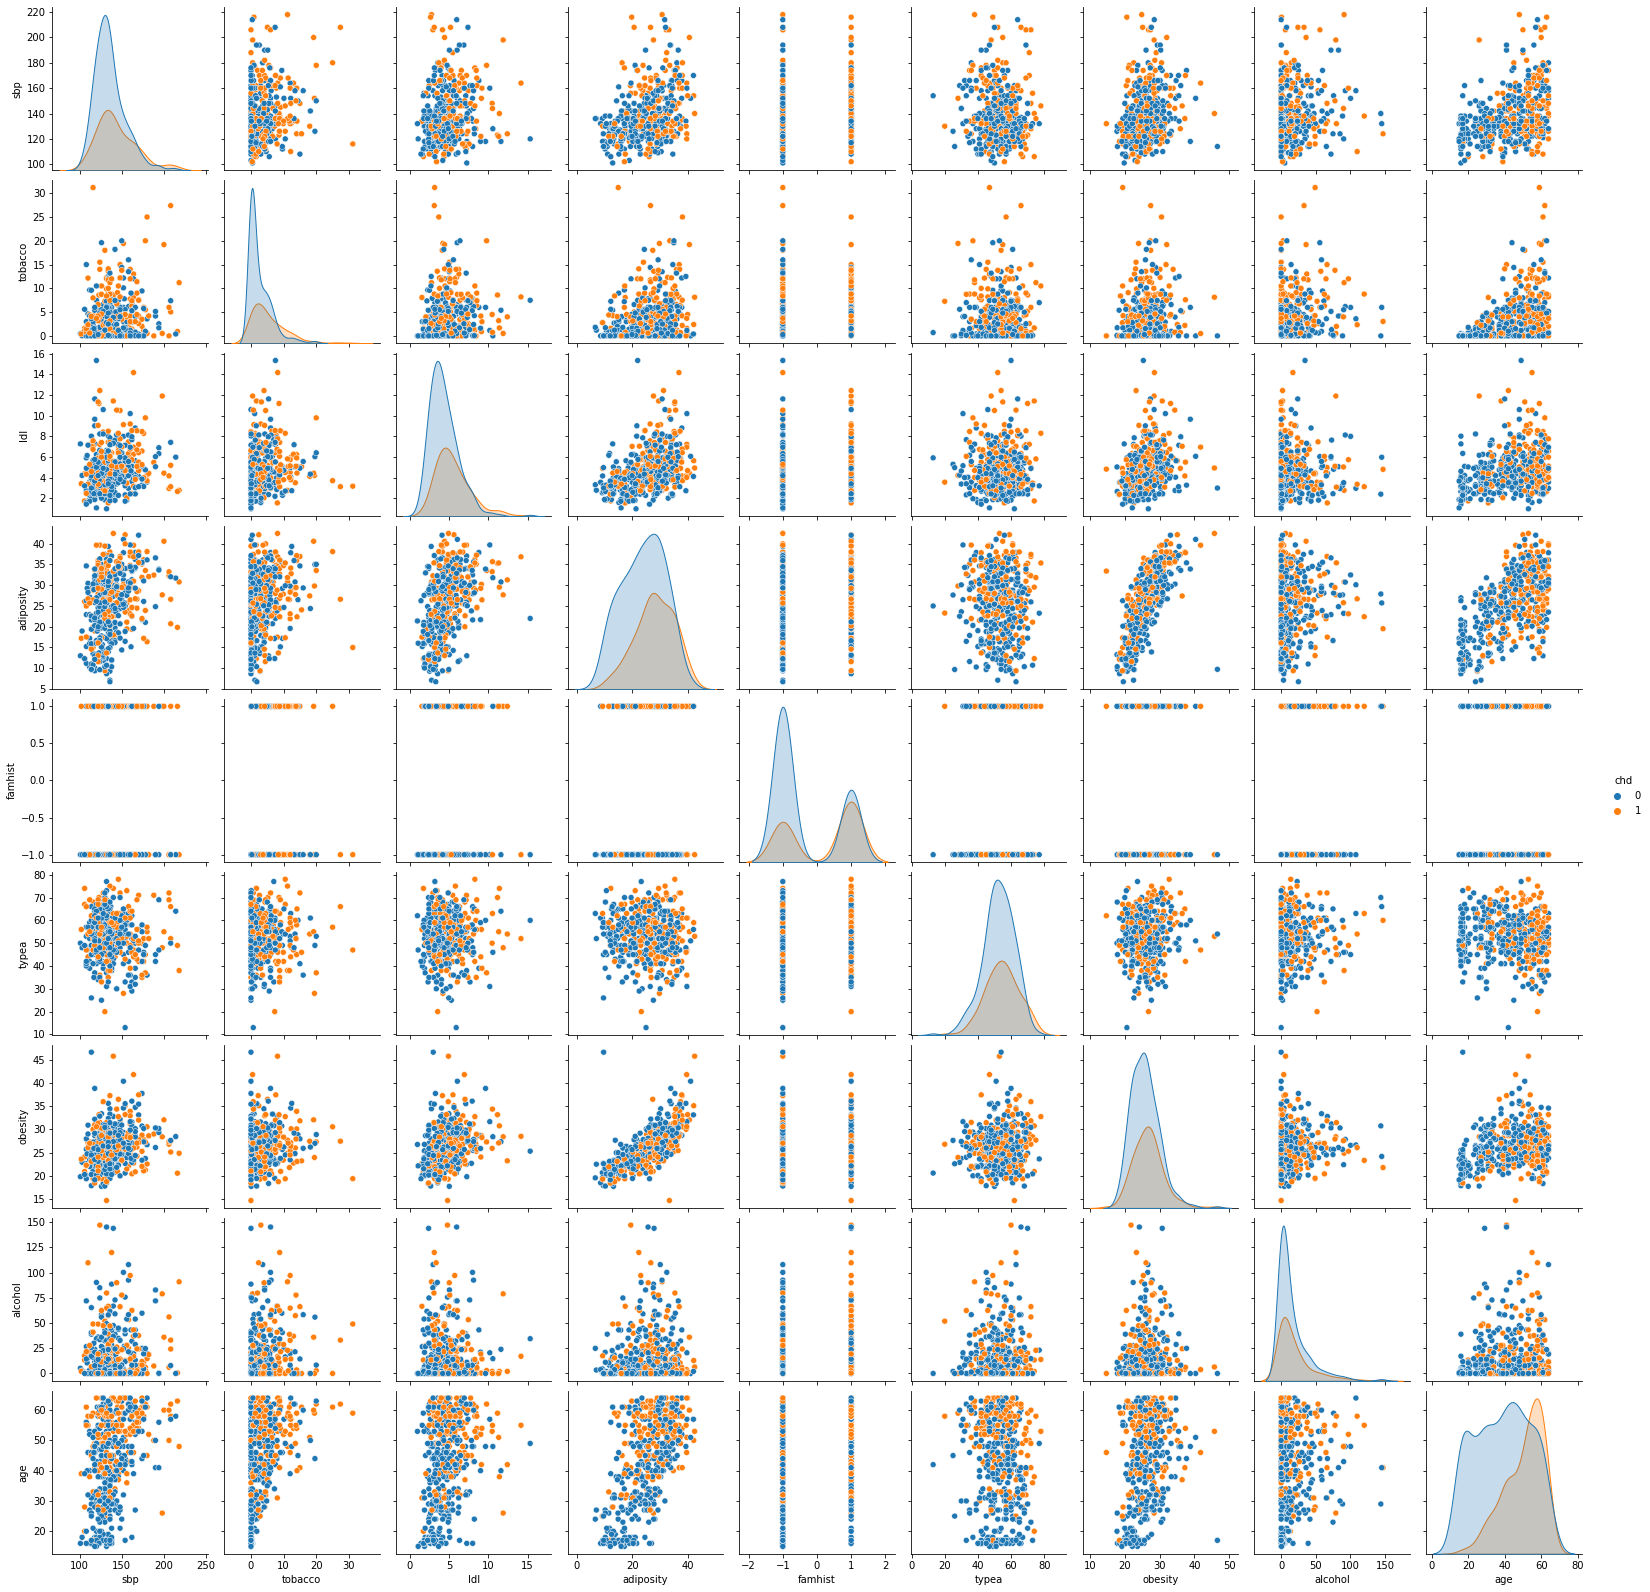

In [ ]:
df, training_features, training_labels, validation_features, validation_labels, testing_features, testing_labels = sa_heart_data()
sns.pairplot(df, hue = 'chd')

In [ ]:
df, training_features, training_labels, validation_features, validation_labels, testing_features, testing_labels = sa_heart_data()

# Unregularized Model
thetas, _ = train(training_features, training_labels, 0.01, np.zeros([1, training_features.shape[1]]), iterations=1000)
accuracy = (percent_correct(testing_features, testing_labels, thetas))

# Stepwise Model
current_initial_thetas, current_test, best_indices = stepwise(training_features, training_labels, 0.01, thetas, validation_features, validation_labels, testing_features, testing_labels)
accuracystep = (percent_correct(current_test, testing_labels, current_initial_thetas))

# L1 Regularization Model
lam1 = validate(training_features, training_labels, 0.01, validation_features, validation_labels, use_l1 = True)
thetas1, _ = train(training_features, training_labels, 0.01, np.zeros([1, training_features.shape[1]]), iterations = 1000, lam=lam1, use_l1 = True)
accuracy1 = (percent_correct(testing_features, testing_labels, thetas1))

# L2 Regularization Model
lam2 = validate(training_features, training_labels, 0.01, validation_features, validation_labels, use_l2 = True)
thetas2, _ = train(training_features, training_labels, 0.01, np.zeros([1, training_features.shape[1]]), iterations = 1000, lam=lam1, use_l2 = True)
accuracy2 = (percent_correct(testing_features, testing_labels, thetas2))

# Display Accuracies
display(pd.DataFrame([["Non-Regularized", accuracy], ["Stepwise", accuracystep], ["L1", accuracy1], ["L2", accuracy2]], columns=["Regularization","Accuracy"]))

# Show best features chosen by Stepwise
print("Important Features Chosen by Stepwise:")

for i in best_indices:
  if(i == 0): print("intercept")
  else: print(list(df.columns.values)[int(i-1)])

,Regularization,Accuracy
0,Non-Regularized,72.357724
1,Stepwise,72.086721
2,L1,75.067751
3,L2,74.254743


Important Features Chosen by Stepwise:
famhist
age
intercept
sbp


### Cervical Cancer Dataset

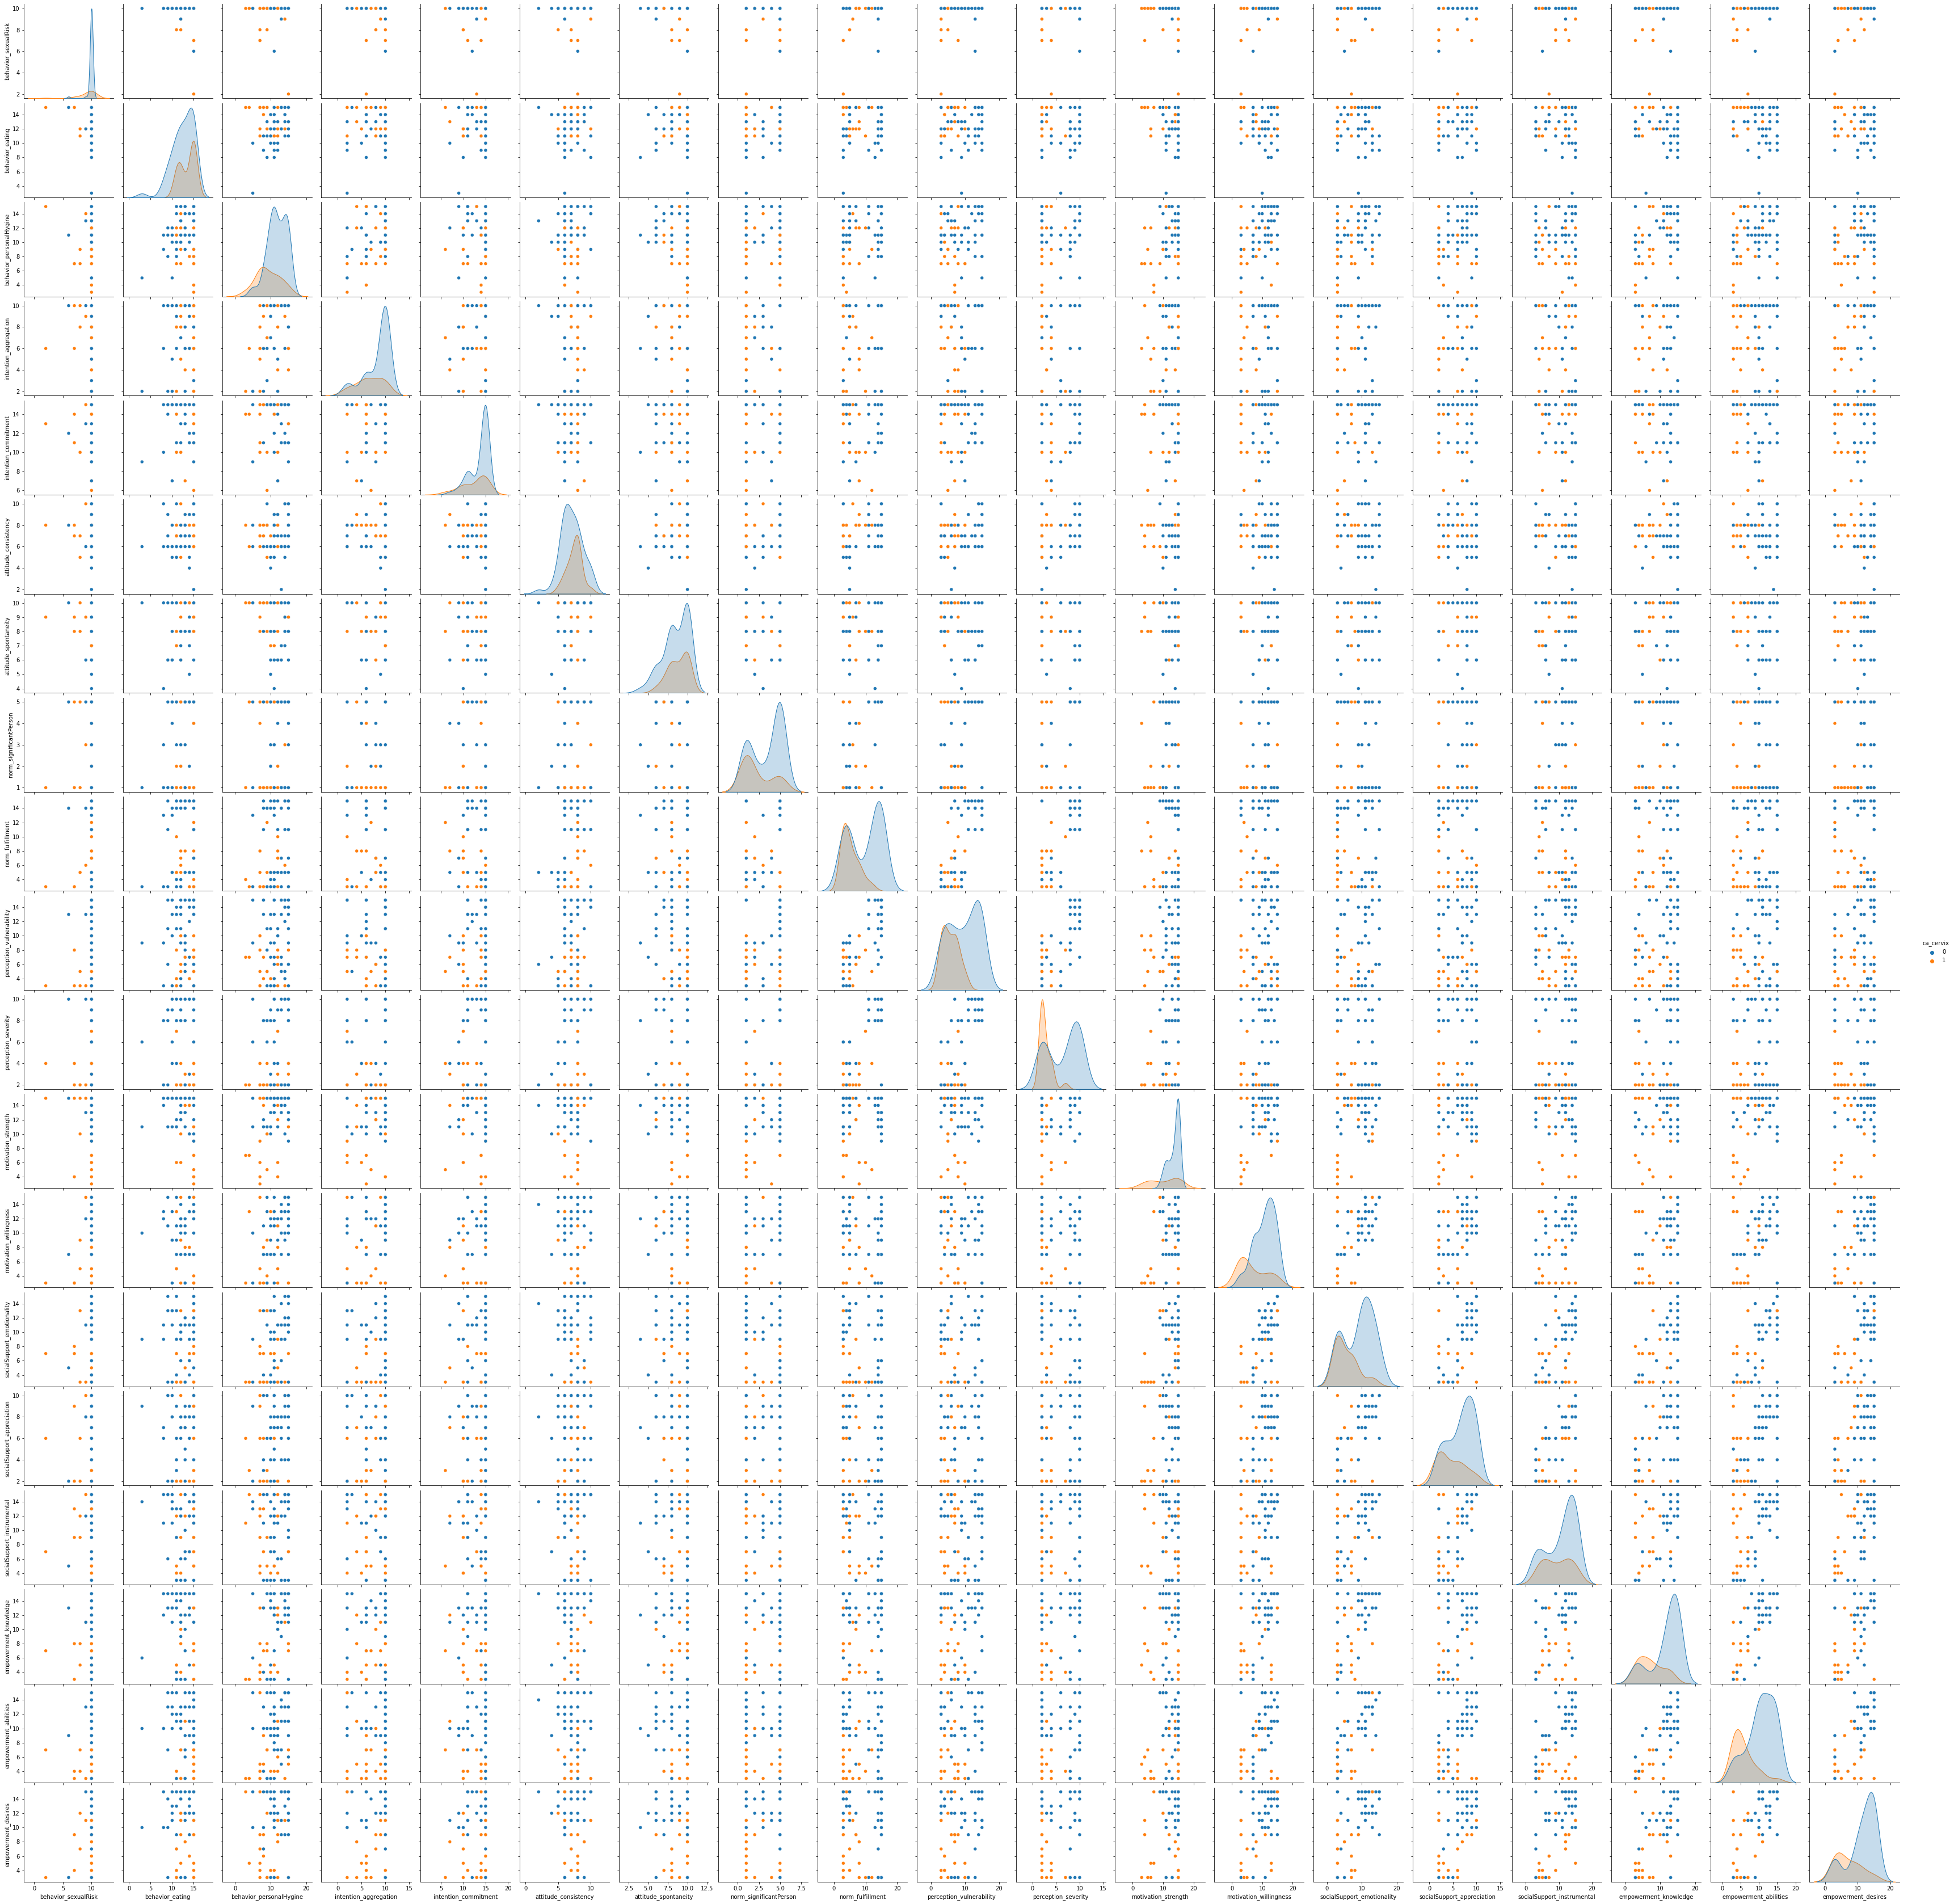

In [ ]:
df, training_features, training_labels, validation_features, validation_labels, testing_features, testing_labels = cervical_cancer()
sns.pairplot(df, hue = 'ca_cervix')

In [ ]:
df, training_features, training_labels, validation_features, validation_labels, testing_features, testing_labels = cervical_cancer()

# Unregularized Model
thetas, _ = train(training_features, training_labels, 0.01, np.zeros([1, training_features.shape[1]]), iterations=1000)
accuracy = (percent_correct(testing_features, testing_labels, thetas))

# Stepwise Model
current_initial_thetas, current_test, best_indices = stepwise(training_features, training_labels, 0.01, thetas, validation_features, validation_labels, testing_features, testing_labels)
accuracystep = (percent_correct(current_test, testing_labels, current_initial_thetas))

# L1 Regularization Model
lam1 = validate(training_features, training_labels, 0.01, validation_features, validation_labels, use_l1 = True)
thetas1, _ = train(training_features, training_labels, 0.01, np.zeros([1, training_features.shape[1]]), iterations = 1000, lam=lam1, use_l1 = True)
accuracy1 = (percent_correct(testing_features, testing_labels, thetas1))

# L2 Regularization Model
lam2 = validate(training_features, training_labels, 0.01, validation_features, validation_labels, use_l2 = True)
thetas2, _ = train(training_features, training_labels, 0.01, np.zeros([1, training_features.shape[1]]), iterations = 1000, lam=lam1, use_l2 = True)
accuracy2 = (percent_correct(testing_features, testing_labels, thetas2))

# Displaying Accuracies
display(pd.DataFrame([["Non-Regularized", accuracy], ["Stepwise", accuracystep], ["L1", accuracy1], ["L2", accuracy2]], columns=["Regularization","Accuracy"]))

# Show best features chosen by Stepwise
print("Important Features Chosen by Stepwise:")
for i in best_indices:
  if(i == 0): print("intercept")
  else: print(list(df.columns.values)[int(i-1)])

,Regularization,Accuracy
0,Non-Regularized,98.245614
1,Stepwise,64.912281
2,L1,98.245614
3,L2,94.736842


Important Features Chosen by Stepwise:
empowerment_desires
behavior_eating
socialSupport_instrumental
behavior_sexualRisk
